In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Paths
grayscale_dir = 'grayscale_images'
rgb_dir = 'colored_images'

# Hyperparameters
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset Class
class Pix2PixDataset(Dataset):
    def __init__(self, grayscale_dir, rgb_dir, transform=None):
        self.grayscale_dir = grayscale_dir
        self.rgb_dir = rgb_dir
        self.files = os.listdir(grayscale_dir)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        gray_path = os.path.join(self.grayscale_dir, self.files[idx])
        rgb_path = os.path.join(self.rgb_dir, self.files[idx])

        gray_img = Image.open(gray_path).convert('L')  # Grayscale
        rgb_img = Image.open(rgb_path).convert('RGB')  # RGB

        if self.transform:
            gray_img = self.transform(gray_img)
            rgb_img = self.transform(rgb_img)

        return gray_img, rgb_img

# Transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# DataLoader
dataset = Pix2PixDataset(grayscale_dir, rgb_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Generator (U-Net)
class GeneratorUNet(nn.Module):
    def __init__(self):
        super(GeneratorUNet, self).__init__()
        def down_block(in_channels, out_channels, apply_batchnorm=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
            if apply_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, dropout=False):
            layers = [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            if dropout:
                layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        # Downsampling layers
        self.down1 = down_block(1, 64, apply_batchnorm=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)

        # Upsampling layers
        self.up1 = up_block(512, 512, dropout=True)
        self.up2 = up_block(1024, 512, dropout=True)
        self.up3 = up_block(1024, 256)
        self.up4 = up_block(512, 128)
        self.up5 = up_block(256, 64)
        self.final = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Downsampling
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)

        # Upsampling
        u1 = self.up1(d6)
        u2 = self.up2(torch.cat([u1, d5], dim=1))
        u3 = self.up3(torch.cat([u2, d4], dim=1))
        u4 = self.up4(torch.cat([u3, d3], dim=1))
        u5 = self.up5(torch.cat([u4, d2], dim=1))
        out = torch.tanh(self.final(torch.cat([u5, d1], dim=1)))

        return out

# Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def block(in_channels, out_channels, stride=2):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.model = nn.Sequential(
            block(4, 64, stride=2),
            block(64, 128, stride=2),
            block(128, 256, stride=2),
            block(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
generator = GeneratorUNet().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

# Optimizers and Loss Functions
criterion_gan = nn.BCEWithLogitsLoss()
criterion_l1 = nn.L1Loss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Training Loop
for epoch in range(EPOCHS):
    for gray, rgb in dataloader:
        gray, rgb = gray.to(DEVICE), rgb.to(DEVICE)

        # Train Discriminator
        fake_rgb = generator(gray)
        real_label = torch.ones((gray.size(0), 1, 30, 30)).to(DEVICE)
        fake_label = torch.zeros((gray.size(0), 1, 30, 30)).to(DEVICE)

        real_loss = criterion_gan(discriminator(torch.cat([gray, rgb], dim=1)), real_label)
        fake_loss = criterion_gan(discriminator(torch.cat([gray, fake_rgb.detach()], dim=1)), fake_label)
        d_loss = (real_loss + fake_loss) / 2

        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        g_loss_gan = criterion_gan(discriminator(torch.cat([gray, fake_rgb], dim=1)), real_label)
        g_loss_l1 = criterion_l1(fake_rgb, rgb)
        g_loss = g_loss_gan + 100 * g_loss_l1

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch + 1}/{EPOCHS}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

print("Training Completed!")

Epoch [1/10], D Loss: 0.3040, G Loss: 23.4825
Epoch [2/10], D Loss: 1.0278, G Loss: 14.9827
Epoch [3/10], D Loss: 0.8181, G Loss: 24.5808
Epoch [4/10], D Loss: 0.3336, G Loss: 17.6078
Epoch [5/10], D Loss: 1.5627, G Loss: 15.1624
Epoch [6/10], D Loss: 0.2710, G Loss: 16.4561
Epoch [7/10], D Loss: 0.4917, G Loss: 12.9633
Epoch [8/10], D Loss: 0.4135, G Loss: 20.9669
Epoch [9/10], D Loss: 1.1082, G Loss: 22.6177
Epoch [10/10], D Loss: 0.0086, G Loss: 18.5508
Training Completed!


In [2]:
# Save the Generator and Discriminator
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")


C:\Users\venka\AppData\Local\Temp\ipykernel_24800\121373505.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(model_path, map_locatio

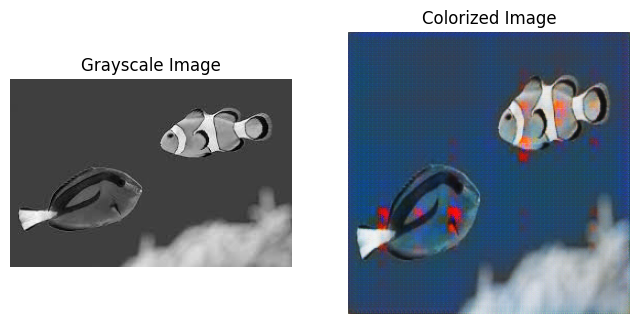

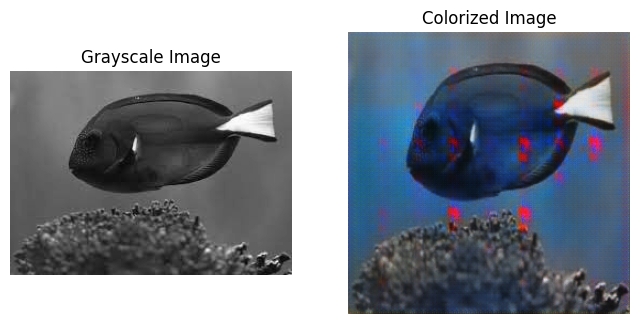

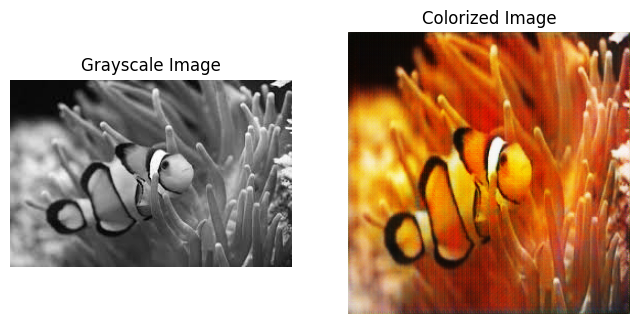

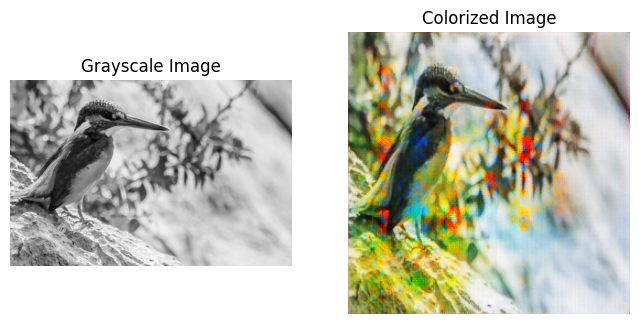

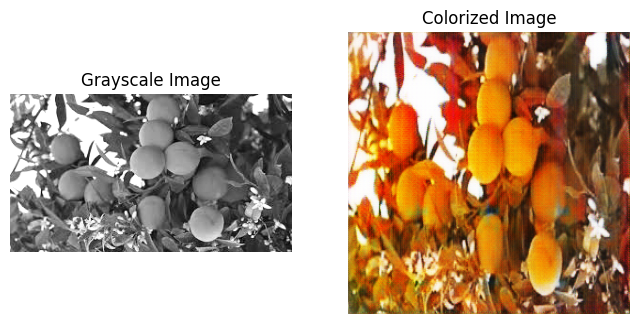

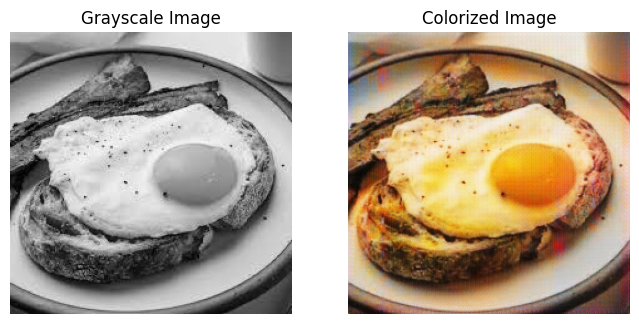

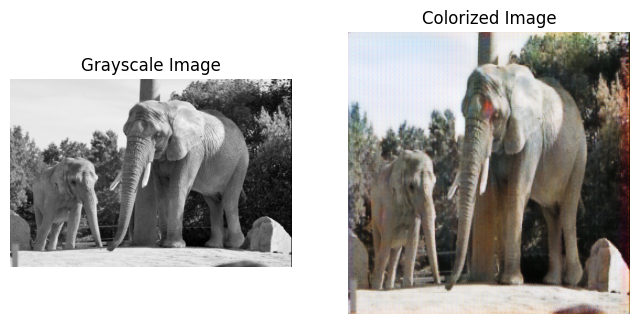

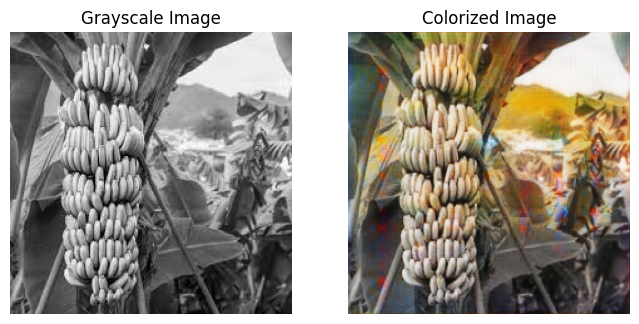

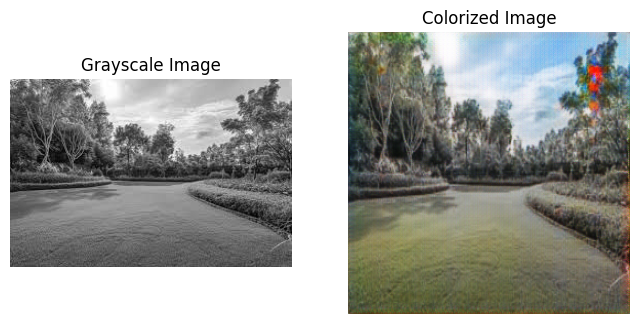

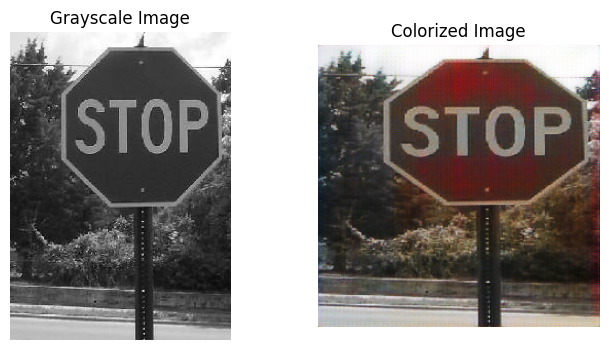

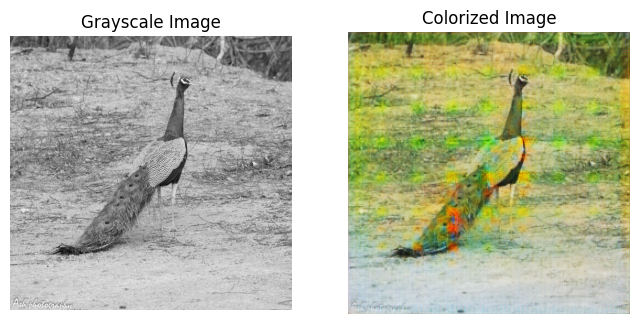

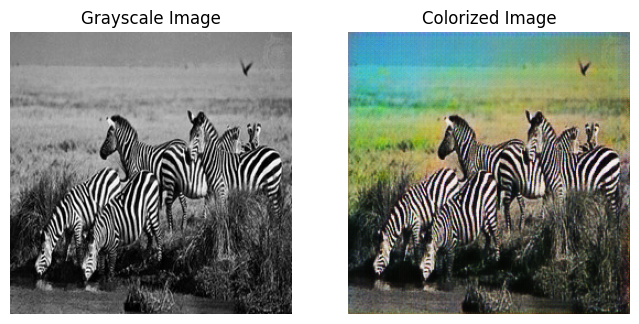

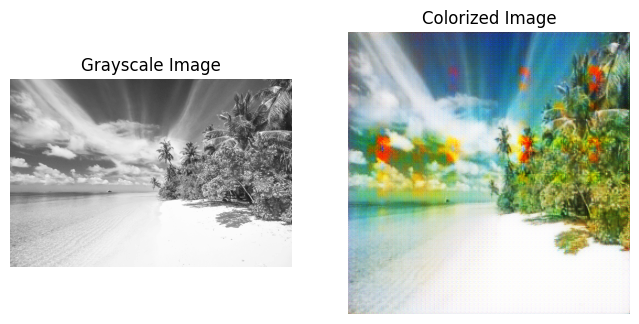

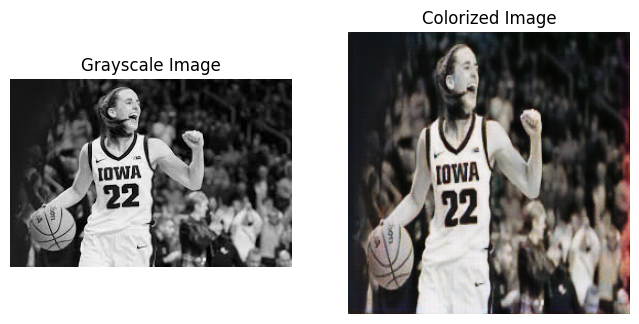

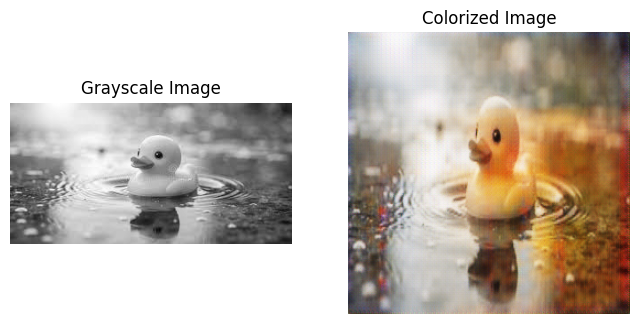

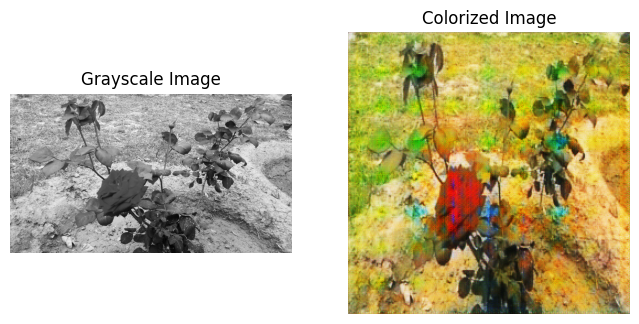

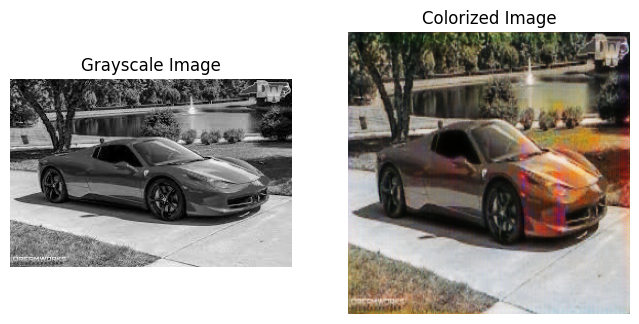

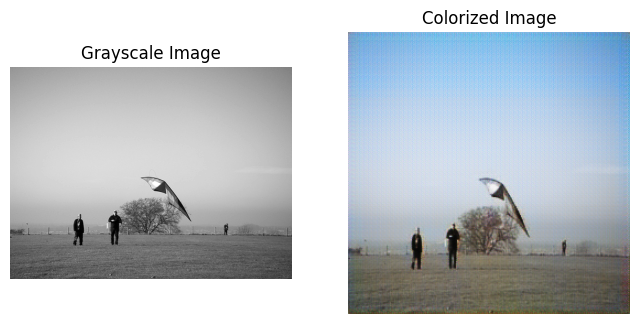

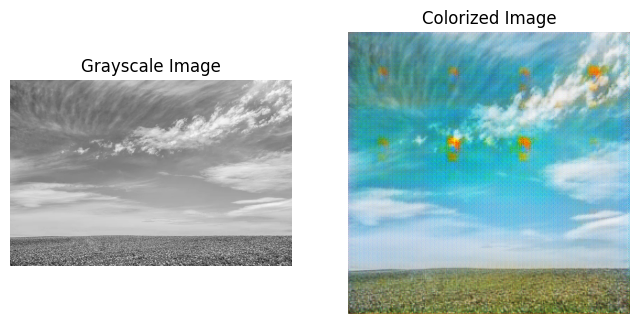

In [38]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Path to the trained generator model
model_path = 'generator.pth'

# Image size and device
IMG_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Trained Generator Model
class GeneratorUNet(torch.nn.Module):
    def __init__(self):
        super(GeneratorUNet, self).__init__()
        def down_block(in_channels, out_channels, apply_batchnorm=True):
            layers = [torch.nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
            if apply_batchnorm:
                layers.append(torch.nn.BatchNorm2d(out_channels))
            layers.append(torch.nn.ReLU(inplace=True))
            return torch.nn.Sequential(*layers)

        def up_block(in_channels, out_channels, dropout=False):
            layers = [
                torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU(inplace=True)
            ]
            if dropout:
                layers.append(torch.nn.Dropout(0.5))
            return torch.nn.Sequential(*layers)

        self.down1 = down_block(1, 64, apply_batchnorm=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)

        self.up1 = up_block(512, 512, dropout=True)
        self.up2 = up_block(1024, 512, dropout=True)
        self.up3 = up_block(1024, 256)
        self.up4 = up_block(512, 128)
        self.up5 = up_block(256, 64)
        self.final = torch.nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)

        u1 = self.up1(d6)
        u2 = self.up2(torch.cat([u1, d5], dim=1))
        u3 = self.up3(torch.cat([u2, d4], dim=1))
        u4 = self.up4(torch.cat([u3, d3], dim=1))
        u5 = self.up5(torch.cat([u4, d2], dim=1))
        out = torch.tanh(self.final(torch.cat([u5, d1], dim=1)))

        return out

# Load the trained generator model
generator = GeneratorUNet().to(DEVICE)
generator.load_state_dict(torch.load(model_path, map_location=DEVICE))
generator.eval()

# Transform for grayscale images
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Function to colorize a single image
def colorize_image(input_image_path):
    # Load and preprocess the grayscale image
    gray_img = Image.open(input_image_path).convert('L')
    input_tensor = transform(gray_img).unsqueeze(0).to(DEVICE)  # Add batch dimension
    
    # Generate colorized image
    with torch.no_grad():
        fake_rgb = generator(input_tensor)
        fake_rgb = (fake_rgb.squeeze(0).permute(1, 2, 0).cpu().numpy() + 1) / 2.0  # Convert to [0, 1]

    # Display the grayscale and colorized images
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Grayscale Image")
    plt.imshow(gray_img, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Colorized Image")
    plt.imshow(fake_rgb)
    plt.axis("off")

    plt.show()

# Input grayscale image path
input_image_path = r"Real images\bt (1).jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\bt (7).jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\cf (11).jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\Common-Kingfisher_18.jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Inputs\download (15)_aug0.png"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\egg (2).jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\el (20).jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\banana_tree.jpeg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\grass.jpeg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\image_0052.jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\Indian-Peacock_157.jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\n02391049_141.jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\pexels-asadphoto-457878.jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\ba1 (2).jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\rd (18).jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\Red Rose New (21).jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\rf (6).jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\sky_image_2.jpg"
colorize_image(input_image_path)

# Input grayscale image path
input_image_path = r"Real images\sky_image.jpeg"
colorize_image(input_image_path)

In [39]:
# Function to colorize and save a single image
def save_colorized_image(input_image_path, output_image_path):
    # Load and preprocess the grayscale image
    gray_img = Image.open(input_image_path).convert('L')
    input_tensor = transform(gray_img).unsqueeze(0).to(DEVICE)  # Add batch dimension

    # Generate colorized image
    with torch.no_grad():
        fake_rgb = generator(input_tensor)
        fake_rgb = (fake_rgb.squeeze(0).permute(1, 2, 0).cpu().numpy() + 1) / 2.0  # Convert to [0, 1]

    # Save the colorized image
    colorized_img = Image.fromarray((fake_rgb * 255).astype('uint8'))
    colorized_img.save(output_image_path)

    print(f"Saved colorized image to {output_image_path}")

# Example usage
output_dir = r"Pix2Pix_Resultant_images"

# Ensure the output directory exists
import os
os.makedirs(output_dir, exist_ok=True)

# List of input grayscale image paths
input_image_paths = [
    r"Real images\bt (1).jpg",
    r"Real images\bt (7).jpg",
    r"Real images\cf (11).jpg",
    r"Real images\Common-Kingfisher_18.jpg",
    r"Inputs\download (15)_aug0.png",
    r"Real images\egg (2).jpg",
    r"Real images\el (20).jpg",
    r"Real images\banana_tree.jpeg",
    r"Real images\grass.jpeg",
    r"Real images\image_0052.jpg",
    r"Real images\Indian-Peacock_157.jpg",
    r"Real images\n02391049_141.jpg",
    r"Real images\pexels-asadphoto-457878.jpg",
    r"Real images\ba1 (2).jpg",
    r"Real images\rd (18).jpg",
    r"Real images\Red Rose New (21).jpg",
    r"Real images\rf (6).jpg",
    r"Real images\sky_image_2.jpg",
    r"Real images\sky_image.jpeg"
]

# Save each colorized image
for input_image_path in input_image_paths:
    # Generate the output file name
    output_image_path = os.path.join(output_dir, os.path.basename(input_image_path).replace('.jpg', '_colorized.jpg').replace('.png', '_colorized.png'))
    save_colorized_image(input_image_path, output_image_path)


Saved colorized image to Pix2Pix_Resultant_images\bt (1)_colorized.jpg
Saved colorized image to Pix2Pix_Resultant_images\bt (7)_colorized.jpg
Saved colorized image to Pix2Pix_Resultant_images\cf (11)_colorized.jpg
Saved colorized image to Pix2Pix_Resultant_images\Common-Kingfisher_18_colorized.jpg
Saved colorized image to Pix2Pix_Resultant_images\download (15)_aug0_colorized.png
Saved colorized image to Pix2Pix_Resultant_images\egg (2)_colorized.jpg
Saved colorized image to Pix2Pix_Resultant_images\el (20)_colorized.jpg
Saved colorized image to Pix2Pix_Resultant_images\banana_tree.jpeg
Saved colorized image to Pix2Pix_Resultant_images\grass.jpeg
Saved colorized image to Pix2Pix_Resultant_images\image_0052_colorized.jpg
Saved colorized image to Pix2Pix_Resultant_images\Indian-Peacock_157_colorized.jpg
Saved colorized image to Pix2Pix_Resultant_images\n02391049_141_colorized.jpg
Saved colorized image to Pix2Pix_Resultant_images\pexels-asadphoto-457878_colorized.jpg
Saved colorized image 